Loading tokenizer and model...
Sentence: 'The cat sat on the mat and stared at the wall.'
Length: 13 tokens
Reduced from 2048D → 12D using PCA
Explained variance ratio: 100.00%

Running diagnostics
Visual 2D PCA explained variance: 33.03%

DEGREE 1
--------------------------------------------------
Embedding MSE:     0.000312
Token accuracy:    23.08%
Reconstructed:     TheTheTheTheThe the the the the the the the the

DEGREE 2
--------------------------------------------------
Embedding MSE:     0.000286
Token accuracy:    30.77%
Reconstructed:     TheThe the the the the the the the..

DEGREE 3
--------------------------------------------------
Embedding MSE:     0.000264
Token accuracy:    38.46%
Reconstructed:     The on on the the the the the the..

DEGREE 4
--------------------------------------------------
Embedding MSE:     0.000240
Token accuracy:    38.46%
Reconstructed:     TheTheThe on on and the the the the the.

DEGREE 5
--------------------------------------------------
Em

/tmp/ipython-input-517184988.py:191: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipython-input-517184988.py:191: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipython-input-517184988.py:193: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans Mono.
  plt.savefig(plot_path, dpi=150, bbox_inches='tight')
/tmp/ipython-input-517184988.py:193: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans Mono.
  plt.savefig(plot_path, dpi=150, bbox_inches='tight')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans M

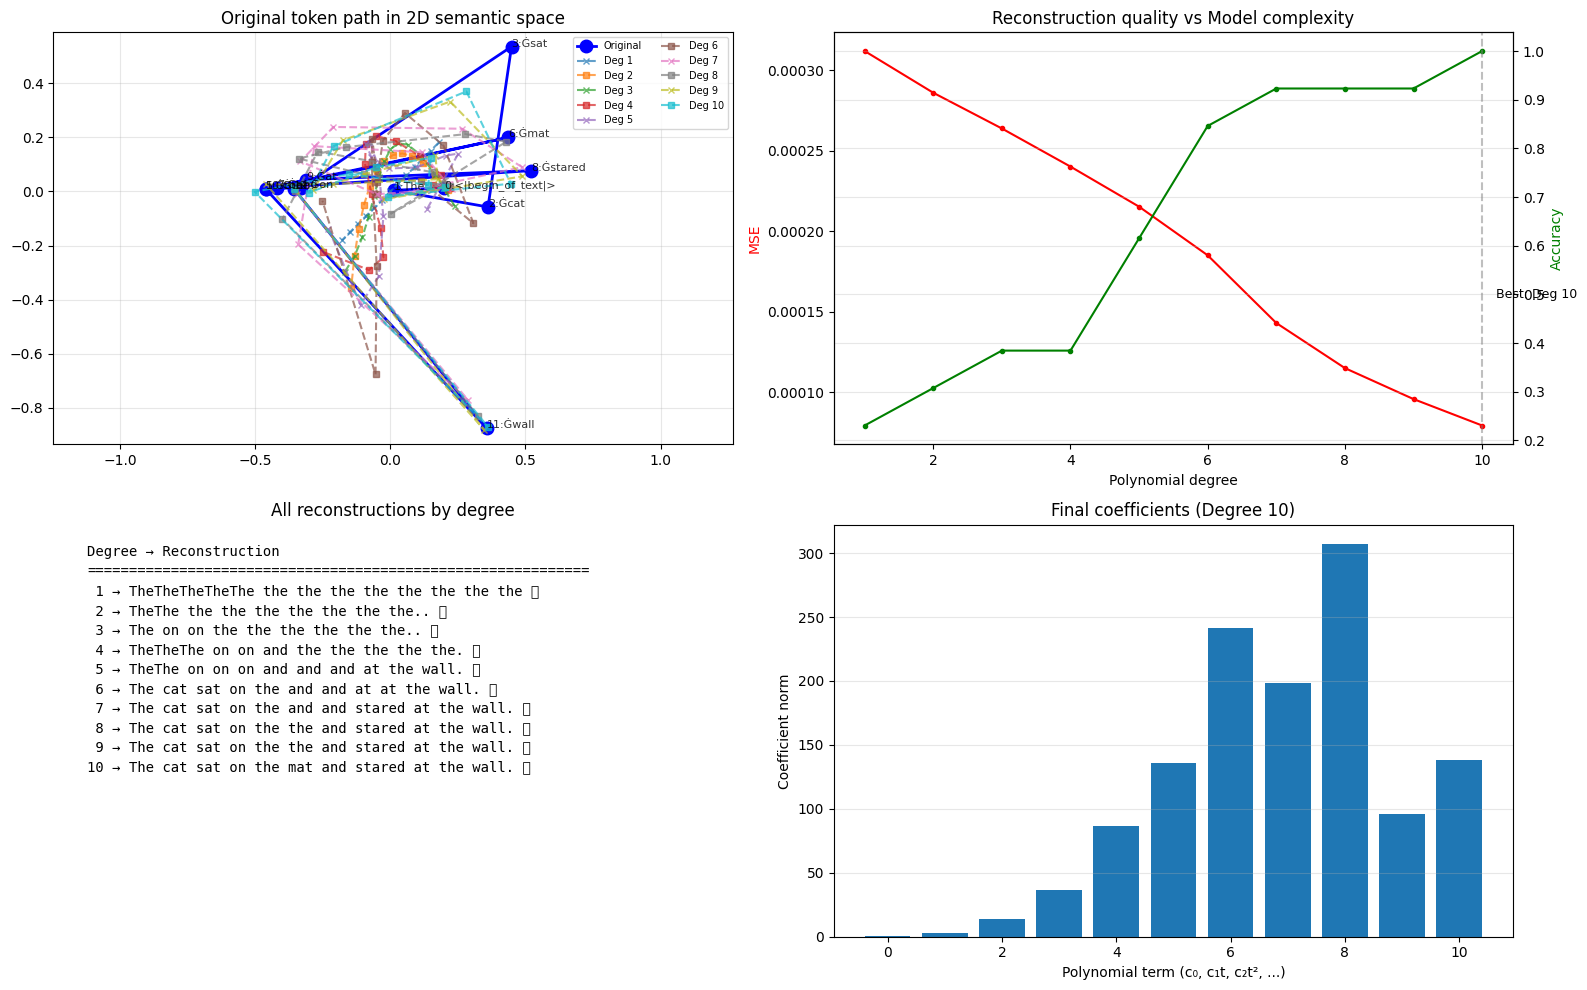


FINAL RESULTS
Best Accuracy:   100.00% at Degree 10
Perfect Match:   Yes
Original:        The cat sat on the mat and stared at the wall.
Best reconstructed: The cat sat on the mat and stared at the wall.

Diagnostic plot saved to:
   ./poly_fixed_output/polynomial_language_diagnostics.png


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
import os

MODEL_NAME = "huihui-ai/Llama-3.2-1B-Instruct-abliterated"
TEXT = "The cat sat on the mat and stared at the wall."
MAX_DEGREE = 10
LAMBDA = 1e-6
COMPONENTS = 64  # Target PCA components (will be capped by sequence length)
OUTPUT_DIR = "./poly_fixed_output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print("Loading tokenizer and model...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME).to(device)
model.eval()

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

inputs = tokenizer(TEXT, return_tensors="pt", truncation=True, max_length=64)
input_ids = inputs.input_ids[0].tolist()
tokens = tokenizer.convert_ids_to_tokens(input_ids)
T = len(tokens)

print(f"Sentence: '{TEXT}'")
print(f"Length: {T} tokens")

with torch.no_grad():
    emb_layer = model.get_input_embeddings()
    embs = emb_layer(inputs.input_ids.to(device))[0].cpu().numpy()  # [T, D]
D = embs.shape[1]

max_components = min(COMPONENTS, T - 1) if T > 1 else 1
pca = PCA(n_components=max_components)
embs_reduced = pca.fit_transform(embs)  # [T, K]

print(f"Reduced from {D}D → {max_components}D using PCA")
print(f"Explained variance ratio: {pca.explained_variance_ratio_.sum():.2%}")

def normalize_time(t, T):
    """Map time index t ∈ [0, T-1] to [-1, 1]"""
    return (t / (T - 1)) * 2 - 1 if T > 1 else 0.0

def fit_poly_curve(ts, ys, degree, lam=LAMBDA):
    """
    Fit vector-valued polynomial P(t) ≈ embedding[t]
    ts: list of time indices [0, ..., T-1]
    ys: reduced-space embeddings [T, K]
    Returns: coeffs [degree+1, K]
    """
    T_len, K = ys.shape
    A = np.zeros((T_len, degree + 1))
    for i, t in enumerate(ts):
        nt = normalize_time(t, T_len)
        for d in range(degree + 1):
            A[i, d] = nt ** d

    AtA = A.T @ A
    AtY = A.T @ ys  # [degree+1, K]
    I_reg = np.eye(degree + 1) * lam
    try:
        coeffs = np.linalg.solve(AtA + I_reg, AtY)
    except np.linalg.LinAlgError as e:
        raise RuntimeError(f"Failed to solve linear system: {e}")
    return coeffs

def evaluate_poly(t, coeffs, T_len):
    nt = normalize_time(t, T_len)
    val = np.zeros(coeffs.shape[1])
    power = 1.0
    for d in range(coeffs.shape[0]):
        val += power * coeffs[d]
        power *= nt
    return val

print("\n" + "="*80)
print("Running diagnostics")
print("="*80)

# For plotting: reduce to 2D for visualization
viz_pca = PCA(n_components=2)
embs_2d = viz_pca.fit_transform(embs)
print(f"Visual 2D PCA explained variance: {viz_pca.explained_variance_ratio_.sum():.2%}")

# Prepare storage
accuracies = []
mse_losses = []
reconstructions = {}
coeff_norms = []

plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
plt.plot(embs_2d[:, 0], embs_2d[:, 1], 'o-', label="Original", color='blue', markersize=9, linewidth=2)
xs = [token.replace('▁', ' ').strip() for token in tokens]
for i, txt in enumerate(xs):
    plt.annotate(f"{i}:{txt}", (embs_2d[i, 0], embs_2d[i, 1]), fontsize=8, alpha=0.8)

plt.legend()
plt.title("Original token path in 2D semantic space")
plt.axis('equal')
plt.grid(True, alpha=0.3)

# Try increasing degrees
ts = list(range(T))
best_acc = 0.0
best_reconstruction = ""
best_degree = 1

for degree in range(1, MAX_DEGREE + 1):
    print(f"\nDEGREE {degree}")
    print("-" * 50)

    coeffs = fit_poly_curve(ts, embs_reduced, degree, LAMBDA)

    gen_reduced = np.array([evaluate_poly(t, coeffs, T) for t in range(T)])
    gen_full = pca.inverse_transform(gen_reduced)

    mse = np.mean((embs - gen_full) ** 2)
    mse_losses.append(mse)

    distances = pairwise_distances(gen_full, embs)
    nearest_indices = distances.argmin(axis=1)
    rec_ids = [input_ids[idx] for idx in nearest_indices]
    rec_text = tokenizer.decode(rec_ids, skip_special_tokens=True)
    reconstructions[degree] = rec_text

    acc = (np.array(rec_ids) == np.array(input_ids)).mean()
    accuracies.append(acc)
    coeff_norms.append(np.linalg.norm(coeffs, axis=1))

    print(f"Embedding MSE:     {mse:.6f}")
    print(f"Token accuracy:    {acc:.2%}")
    print(f"Reconstructed:     {rec_text}")

    # Update best
    if acc > best_acc:
        best_acc = acc
        best_reconstruction = rec_text
        best_degree = degree

    gen_2d = viz_pca.transform(gen_full)
    style = '--x' if degree % 2 == 1 else '--s'
    plt.subplot(2, 2, 1)
    plt.plot(gen_2d[:, 0], gen_2d[:, 1], style, label=f"Deg {degree}", alpha=0.7, markersize=4)

plt.legend(fontsize=7, ncol=2)

plt.subplot(2, 2, 2)
degrees_range = list(range(1, MAX_DEGREE + 1))
plt.plot(degrees_range, mse_losses, 'r.-', label='MSE (↓)')
plt.ylabel("MSE", color='red')
plt.xlabel("Polynomial degree")
plt.twinx()
plt.plot(degrees_range, accuracies, 'g.-', label='Accuracy (↑)')
plt.ylabel("Accuracy", color='green')
plt.title("Reconstruction quality vs Model complexity")
plt.grid(True, alpha=0.3)
plt.axvline(best_degree, color='gray', linestyle='--', alpha=0.5)
plt.text(best_degree + 0.2, 0.5, f'Best: Deg {best_degree}', va='center', fontsize=9)

plt.subplot(2, 2, 3)
table_text = "Degree → Reconstruction\n" + "=" * 60 + "\n"
for deg, txt in reconstructions.items():
    check = "✅" if txt.strip() == TEXT.strip() else "❌"
    table_text += f"{deg:2d} → {txt} {check}\n"
plt.axis('off')
plt.text(0.05, 0.95, table_text, fontsize=10, fontfamily='monospace',
         verticalalignment='top', horizontalalignment='left', linespacing=1.5)
plt.title("All reconstructions by degree")

plt.subplot(2, 2, 4)
final_coeffs = coeff_norms[-1]  # Last fitted coefficients
plt.bar(range(len(final_coeffs)), final_coeffs)
plt.xlabel("Polynomial term (c₀, c₁t, c₂t², ...)")
plt.ylabel("Coefficient norm")
plt.title(f"Final coefficients (Degree {MAX_DEGREE})")
plt.grid(True, axis='y', alpha=0.3)

# Final layout
plt.tight_layout()
plot_path = os.path.join(OUTPUT_DIR, "polynomial_language_diagnostics.png")
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("FINAL RESULTS")
print("="*80)
print(f"Best Accuracy:   {best_acc:.2%} at Degree {best_degree}")
print(f"Perfect Match:   {'Yes' if best_reconstruction.strip() == TEXT.strip() else 'No'}")
print(f"Original:        {TEXT}")
print(f"Best reconstructed: {best_reconstruction}")
print(f"\nDiagnostic plot saved to:\n   {plot_path}")

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import pairwise_distances
import os

MODEL_NAME = "huihui-ai/Llama-3.2-1B-Instruct-abliterated"
OUTPUT_DIR = "./poly_generative_output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# structured training sentences (same syntactic pattern)
TEXT_SAMPLES = [
    "The cat sat on the mat.",
    "The dog slept on the rug.",
    "The bird perched on the branch.",
    "The child played on the grass.",
    "The teacher stood at the board.",
    "The chef cooked in the kitchen.",
    "The student read at the desk."
]

MAX_DEGREE = 8            # Polynomial degree
LAMBDA = 1e-6             # Tikhonov regularization
COMPONENTS = 32           # PCA components
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print("Loading tokenizer and model...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME).to(device)
model.eval()

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Find max length for padding
max_len = max(len(tokenizer.encode(txt)) for txt in TEXT_SAMPLES)
embeddings_list = []

print(f"\nUsing {len(TEXT_SAMPLES)} training sentences:")
for i, txt in enumerate(TEXT_SAMPLES):
    print(f"  {i}: {txt}")
    inputs = tokenizer(txt, return_tensors="pt", truncation=True, max_length=64)
    input_ids = inputs.input_ids[0].tolist()

    with torch.no_grad():
        embs = model.get_input_embeddings()(inputs.input_ids.to(device))[0].cpu().numpy()  # [T_i, D]

    # Pad to max_len
    pad_len = max_len - embs.shape[0]
    if pad_len > 0:
        embs = np.pad(embs, ((0, pad_len), (0, 0)), mode='constant', constant_values=0)

    embeddings_list.append(embs)

all_embs = np.stack(embeddings_list)  # [B, T, D]
B, T, D = all_embs.shape

flat_to_id = []
for txt in TEXT_SAMPLES:
    ids = tokenizer.encode(txt)  # List of real token IDs
    padded_ids = ids + [tokenizer.pad_token_id] * (max_len - len(ids))
    flat_to_id.extend(padded_ids)  # Append all in order

all_flat_embs = all_embs.reshape(-1, D)  # [B*T, D]
assert len(flat_to_id) == len(all_flat_embs), "Mismatch between embeddings and token IDs"

print(f"\nTotal flattened embeddings: {len(all_flat_embs)}")
print(f"Reducing from {D}D embedding space...")

pca = PCA(n_components=min(COMPONENTS, D))
embs_reduced = pca.fit_transform(all_flat_embs).reshape(B, T, -1)  # [B, T, K]
explained_var = pca.explained_variance_ratio_.sum()
print(f"Reduced to {COMPONENTS}D | Explained variance: {explained_var:.2%}")

def normalize_time(t, T):
    return (t / (T - 1)) * 2 - 1 if T > 1 else 0.0

ts = np.arange(T)
A = np.zeros((T, MAX_DEGREE + 1))
for i, t in enumerate(ts):
    nt = normalize_time(t, T)
    for d in range(MAX_DEGREE + 1):
        A[i, d] = nt ** d

mean_traj = np.mean(embs_reduced, axis=0)  # [T, K]

# Solve regularized least squares: (A^T A + λI) x = A^T Y
AtA = A.T @ A
AtY = A.T @ mean_traj  # [degree+1, K]
I_reg = np.eye(MAX_DEGREE + 1) * LAMBDA
coeffs = np.linalg.solve(AtA + I_reg, AtY)  # [degree+1, K]

print("Fitted global polynomial over shared sentence structure.")

def generate_sentence(coeffs, T, pca, modify_fn=None):
    """
    Evaluate polynomial curve and decode to text.
    Optionally modify the generated reduced-space path.
    """

    gen_reduced = np.array([
        sum((normalize_time(t, T) ** d) * coeffs[d] for d in range(len(coeffs)))
        for t in range(T)
    ])  # [T, K]


    if modify_fn is not None:
        gen_reduced = modify_fn(gen_reduced)


    gen_full = pca.inverse_transform(gen_reduced)  # [T, D]


    distances = pairwise_distances(gen_full, all_flat_embs, metric='cosine')  # also euclidian?
    nearest_indices = distances.argmin(axis=1)  # [T]


    rec_ids = [flat_to_id[idx] for idx in nearest_indices]


    valid_ids = [tid for tid in rec_ids if tid != tokenizer.pad_token_id]
    try:
        text = tokenizer.decode(valid_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
        return text.strip(), rec_ids
    except Exception as e:
        print(f"Decoding error: {e}")
        return "[invalid]", rec_ids


print("\n" + "="*60)
print("GENERATIVE OUTPUTS")
print("="*60)

base_text, _ = generate_sentence(coeffs, T, pca)
print(f"Base: {base_text}")

def grow_curve(reduced):
    extended = []
    for t in range(T + 3):  # slight extrapolation
        nt = normalize_time(t, T + 3)
        val = sum((nt ** d) * coeffs[d] for d in range(len(coeffs)))
        extended.append(val)
    return np.array(extended[-T:])  # use last T steps

longer_text, _ = generate_sentence(coeffs, T, pca, modify_fn=grow_curve)
print(f"Extended:  {longer_text}")

def sharpen_curve(reduced):
    mod_coeffs = coeffs.copy()
    for d in range(5, len(mod_coeffs)):
        mod_coeffs[d] *= 1.8  # boost higher-order terms
    return np.array([
        sum((normalize_time(t, T) ** d) * mod_coeffs[d] for d in range(len(mod_coeffs)))
        for t in range(T)
    ])

sharpened_text, _ = generate_sentence(coeffs, T, pca, modify_fn=sharpen_curve)
print(f"Sharpened:   {sharpened_text}")

def noisy_curve(reduced):
    noise = np.random.normal(0, 0.015, reduced.shape)
    return reduced + noise

noisy_text, _ = generate_sentence(coeffs, T, pca, modify_fn=noisy_curve)
print(f"Creative:   {noisy_text}")

def reverse_curve(reduced):
    return reduced[::-1]

reversed_text, _ = generate_sentence(coeffs, T, pca, modify_fn=reverse_curve)
print(f"Reversed:   {reversed_text}")


output_path = os.path.join(OUTPUT_DIR, "generations.txt")
with open(output_path, "w") as f:
    f.write(f"Base: {base_text}\n")
    f.write(f"Extended:  {longer_text}\n")
    f.write(f"Sharpened:  {sharpened_text}\n")
    f.write(f"Creative:  {noisy_text}\n")
    f.write(f"Reversed:  {reversed_text}\n")

print(f"\nSaved generations to: {output_path}")

Loading tokenizer and model...

Using 7 training sentences:
  0: The cat sat on the mat.
  1: The dog slept on the rug.
  2: The bird perched on the branch.
  3: The child played on the grass.
  4: The teacher stood at the board.
  5: The chef cooked in the kitchen.
  6: The student read at the desk.

Total flattened embeddings: 63
Reducing from 2048D embedding space...
Reduced to 32D | Explained variance: 100.00%
Fitted global polynomial over shared sentence structure.

GENERATIVE OUTPUTS
Base: The dog sat on the mat..
Extended:  dog slept on on the the rug..
Sharpened:   slept slept slept slept on the the the the
Creative:   The cat sat on the mat..
Reversed:   .. mat the on sat dogThe

Saved generations to: ./poly_generative_output/generations.txt
